In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML

def display_sticky_table(df, height=400):
    html = f"""
    <style>
    .tableFixHead {{
        overflow-y: auto;
        height: {height}px;
    }}
    .tableFixHead thead th {{
        position: sticky;
        top: 0;
        background-color: gray;
        z-index: 1;
    }}
    </style>
    <div class="tableFixHead">
        {df.to_html()}
    </div>
    """
    return HTML(html)

In [3]:
seq_dict = {"601":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601RTA":"CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCTACCGCGTTTTAACCGCCAATAGGATTACTTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT", 
            "601MF": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACACCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT",
            "601L": "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG",
            "5S": "CTTCCAGGGATTTATAAGCCGATGACGTCATAACATCCCTGACCCTTTAAATAGCTTAACTTTCATCAAGCAAGAGCCTACGACCATACCATGCTGAATATACCGGTTCTCGTCCGATCACCGAAGTCAAGCAGCATAGGGCTCGGT"  }

nucmethod = "hybrid"

In [4]:
import os 
import sys
from py_analysis.modules.NucFreeEnergy import NucleosomeBreath
from py_analysis.config.custom_types import FreeEnergyResult, NuclBreathingResult
from py_analysis.config.gen_var import RESULTS_DIR, HARD_CONS
from typing import List
import concurrent.futures
from tqdm import tqdm
import pandas as pd



Source Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucMonteCarlo
Output Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/NucMonteCarlo


In [5]:

LEN_BOUND_SITES = 14
states = []
for left in range(LEN_BOUND_SITES):  # Left binding site: 0 to 13
    for right in range(left, LEN_BOUND_SITES):  # Right must be ≥ left
        states.append((left, right))

print(f"Total states index wise: {len(states)}")
## Use this for style="b_index"

##############################################################################
##############################################################################
##############################################################################
# This is the code to generate the states for the phosphate binding sites
# The phosphate binding sites are 0 to 27, and the left and right binding sites

LEN_PHOSPHATE_SITES = 28
ph_states = []
for left in range(LEN_PHOSPHATE_SITES):  # Left binding site: 0 to 27
    for right in range(left, LEN_PHOSPHATE_SITES):  # Right must be ≥ left
        ph_states.append((left, right))

print(f"Total phosphate states index wise: {len(ph_states)}")
## Use this for style="ph_index"

##############################################################################
##############################################################################
##############################################################################
## This is the code to generate the states for the open binding sites

# open_states = []
# for left in range(29): 
#     for right in range(29):  
#         if left+right <= 28: # Left and right binding sites must not exceed 28
#             open_states.append((left, right))

# print(f"Total open states: {len(open_states)}")
# ## Use this for style="open_sites"

Total states index wise: 105
Total phosphate states index wise: 406


In [6]:
KRESCFACTOR = 1.0
STYLE = "ph_index"  # Change this to "ph_index" for phosphate binding sites

if STYLE == "b_index":
    stat_list = states
    LENGTH = LEN_BOUND_SITES

elif STYLE == "ph_index":
    stat_list = ph_states
    LENGTH = LEN_PHOSPHATE_SITES

elif STYLE == "open_sites":
    stat_list = open_states
else:
    raise ValueError("Invalid style. Choose 'b_index', 'ph_index', or 'open_sites'.")

In [7]:

def energy_per_sequence(key, seq, nucmethod:str, bind_sates:List[tuple], factor, hard:bool=False, style:str="b_index")->  List[NuclBreathingResult]:
    nucleosomebreath = NucleosomeBreath(nuc_method=nucmethod)
    results:List[NuclBreathingResult] = []

    for bind_loc in bind_sates:

        if hard:
            free_energy = nucleosomebreath.calculate_free_energy_hard(seq147=seq,
                                                                    left=bind_loc[0], right=bind_loc[1], id=key)

        else:
            free_energy = nucleosomebreath.calculate_free_energy_soft(seq601=seq, 
                                                                  left=bind_loc[0], right=bind_loc[1], id=key, kresc_factor=factor, style=style)
            
        res_nucbreath = NuclBreathingResult(
            id=key,
            subid=None,
            sequence=seq,
            leftbind_indx=bind_loc[0],
            rightbind_indx=bind_loc[1],
            F_vals=free_energy
        )
        results.append(res_nucbreath)

    return results

results_all:List[NuclBreathingResult] = []
with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:

    # futures = [executor.submit(energy_per_sequence, key=s, seq=seq_dict[s], nucmethod='hybrid', bind_sates=states, factor=KRESCFACTOR, hard=HARD_CONS, style="os") for s in seq_dict.keys()]
    futures = [executor.submit(energy_per_sequence, key=s, seq=seq_dict[s], nucmethod='hybrid', bind_sates=stat_list, factor=KRESCFACTOR, hard=HARD_CONS, style=STYLE) for s in list(seq_dict.keys())[:1]
]

    total = len(futures)

    for future in tqdm(concurrent.futures.as_completed(futures), total=total, desc="Processing sequences"):
        energy_array = future.result()
        results_all.extend(energy_array)

Processing sequences:   0%|          | 0/1 [00:00<?, ?it/s]

Using nucleosome method: hybrid
Using hang DNA method: md
Using hang stiffness: False


Processing sequences: 100%|██████████| 1/1 [03:20<00:00, 200.54s/it]


In [8]:

df_results = pd.DataFrame([result._asdict() for result in results_all])
df_free_energy = df_results['F_vals'].apply(lambda x: x._asdict() if hasattr(x, '_asdict') else x).apply(pd.Series)
df_free_energy = df_free_energy[['F', 'F_entropy', 'F_enthalpy', 'F_freedna']]

df_full = pd.concat([df_results.drop(columns=['F_vals']), df_free_energy], axis=1)
df_full["dF"] = df_full["F"] - df_full["F_freedna"]


In [9]:


if STYLE == "b_index" or STYLE == "ph_index":
    df_full["left_open"] = df_full["leftbind_indx"]
    df_full["right_open"] = df_full["rightbind_indx"].apply(lambda x: (LENGTH-1) - x)

else:
    df_full["left_open"] = df_full["leftbind_indx"]
    df_full["right_open"] = df_full["rightbind_indx"]


In [10]:
df_full

,id,subid,sequence,leftbind_indx,rightbind_indx,Adsorp_F,F,F_entropy,F_enthalpy,F_freedna,dF,left_open,right_open
0,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,0,0.0,1650.286369,1650.286369,0.000000,1650.286369,0.000000,0,27
1,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,1,0.0,1652.048613,1652.037907,0.010706,1650.286369,1.762244,0,26
2,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,2,0.0,1655.467528,1655.207036,0.260492,1650.286369,5.181159,0,25
3,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,3,0.0,1657.366950,1656.724465,0.642485,1650.286369,7.080581,0,24
4,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,0,4,0.0,1661.593102,1659.067487,2.525616,1650.286369,11.306734,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,25,26,0.0,1653.358394,1653.298774,0.059619,1650.286369,3.072025,25,1
402,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,25,27,0.0,1655.551284,1655.246482,0.304803,1650.286369,5.264916,25,0
403,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,26,26,0.0,1650.286369,1650.286369,0.000000,1650.286369,0.000000,26,1
404,601,None,CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCT...,26,27,0.0,1652.050976,1652.037353,0.013623,1650.286369,1.764607,26,0


In [8]:
if HARD_CONS:
    df_full.to_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_hc.csv", index=False)
else:
    df_full.to_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_sc.csv", index=False)


# df_full.to_csv("free_energy_results_hard.csv", index=False)

# Nuc Breathing using the constant Adsorption energy values

In [119]:
KRESCFACTOR = 1.0

if HARD_CONS:
    ############## HARD CONSTRAITNS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_hc.csv")
else:
    ############## SOFT CONSTRAINTS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_sc.csv")

In [120]:
import numpy as np
import matplotlib.pyplot as plt

from py_analysis.utils.plot_2d_heatmaps import plot_probability_heatmaps

from py_analysis.utils.plot_3d import plot_3d_filled_volume

/tmp/ipykernel_1002047/843268016.py:28: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



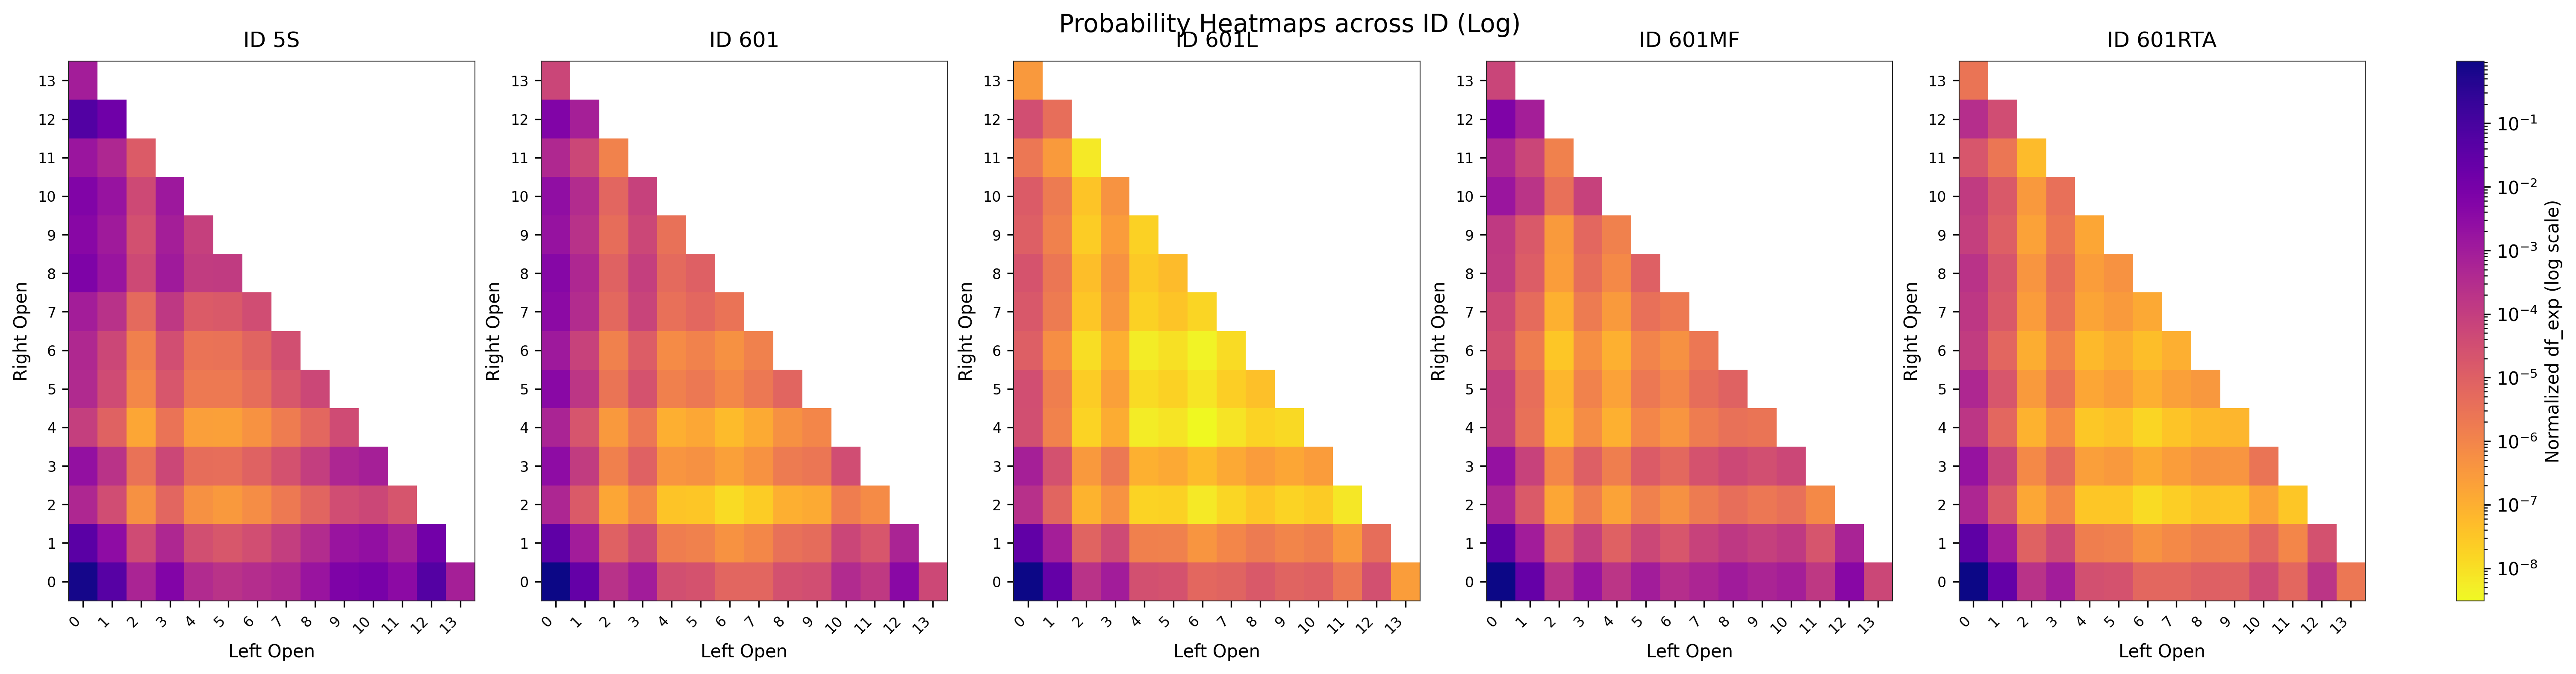

In [123]:

E_ads=16.5

df_full["Adsorp_F"]= -E_ads*(14-(df_full["left_open"]+df_full["right_open"]))

# df_full = apply_Eads(df_full, E_ads_high=26.0, E_ads_low=25.0)

df_full["dF_total"] = df_full["dF"] + df_full["Adsorp_F"]
# df_full["dF_total"] = df_full["F_enthalpy"] + df_full["Adsorp_F"]


df_full["df_exp"]= df_full["dF_total"].apply(lambda x: np.exp(-x))
df_full["df_exp_norm"] = df_full.groupby("id")["df_exp"].transform(lambda x: x / x.sum())


fig, axs = plot_probability_heatmaps(
    df_full,
    value_col='df_exp_norm',
    id_col='id',
    x_col='left_open',
    y_col='right_open',
    xlabel='Left Open',
    ylabel='Right Open',
    log_scale=True,
    colormap='plasma_r',
    figsize=(20, 5),
    suptitle="Probability Heatmaps across ID (Log)", dpi=300, colorbar_label = 'Normalized df_exp (log scale)'
)
fig.show()

In [91]:
fig2 = plot_3d_filled_volume(
    df_full,
    x_col='left_open', y_col='right_open', z_col='dF_total',
    x_label='Left Opening',
    y_label='Right Opening',
    z_label='ΔF (kT)',
    width=800, height=600,
    title='Free‐Energy Landscapes',
    colorscale='Plasma_r'
)
fig2.show()


# Calculate the Adsorption Energy from Michelle Wang data (2009) 

### doi:10.1038/nsmb.1526

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_analysis.config.gen_var import RESULTS_DIR, DATA_DIR


In [142]:
PHOSPHATE_SITES: List[int] = [
    2, 6, 14, 17, 24, 29, 34, 38,
    45, 49, 55, 59, 65, 69, 76,
    80, 86, 90, 96, 100, 107, 111,
    116, 121, 128, 131, 139, 143,
]

In [143]:
left_zip_df = pd.read_csv(DATA_DIR / f"Hall_forward_zip_dwelltime_clean.csv", header=None, names=["basepair", "dwelltime"])
right_zip_df = pd.read_csv(DATA_DIR / f"Hall_reverse_zip_dwelltime_clean.csv", header=None, names=["basepair", "dwelltime"])

left_zip_df["bp_pos"] = left_zip_df["basepair"]+73
left_zip_df.loc[left_zip_df['dwelltime'] < 0, 'dwelltime'] = 0
left_zip_df = left_zip_df.sort_values('bp_pos')
left_zip_df['cumulative_dwell_time'] = left_zip_df['dwelltime'].cumsum()

right_zip_df["bp_pos"] = right_zip_df["basepair"]+73
right_zip_df.loc[right_zip_df['dwelltime'] < 0, 'dwelltime'] = 0
right_zip_df = right_zip_df.sort_values('bp_pos')
right_zip_df['cumulative_dwell_time'] = right_zip_df['dwelltime'][::-1].cumsum()[::-1] ## cumulative sum for right zip

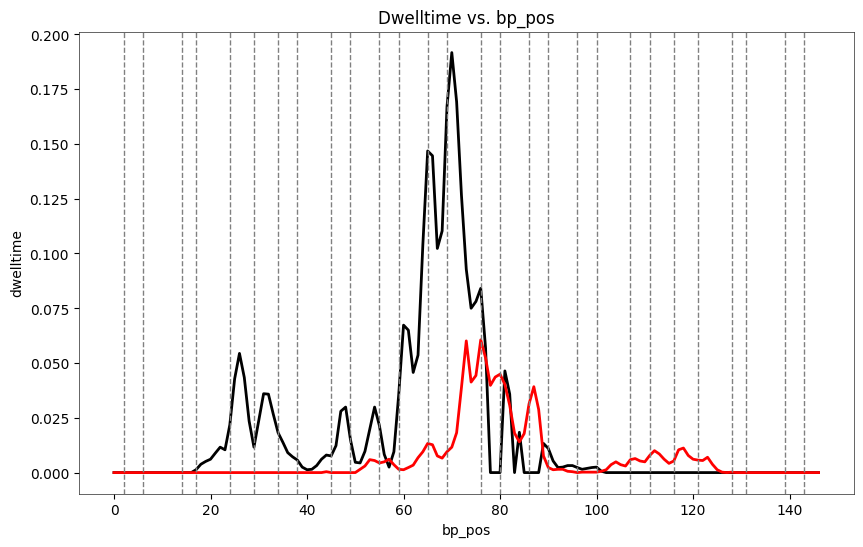

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(left_zip_df['bp_pos'], left_zip_df['dwelltime'], lw=2, color='black', label='Left Zip')
plt.plot(right_zip_df['bp_pos'], right_zip_df['dwelltime'], lw=2, color='red', label='Right Zip')
for site in PHOSPHATE_SITES:
    plt.axvline(site, color='gray', linestyle='--', lw=1)
plt.xlabel('bp_pos')
plt.ylabel('dwelltime')
plt.title('Dwelltime vs. bp_pos')
# plt.grid(True)
plt.show()

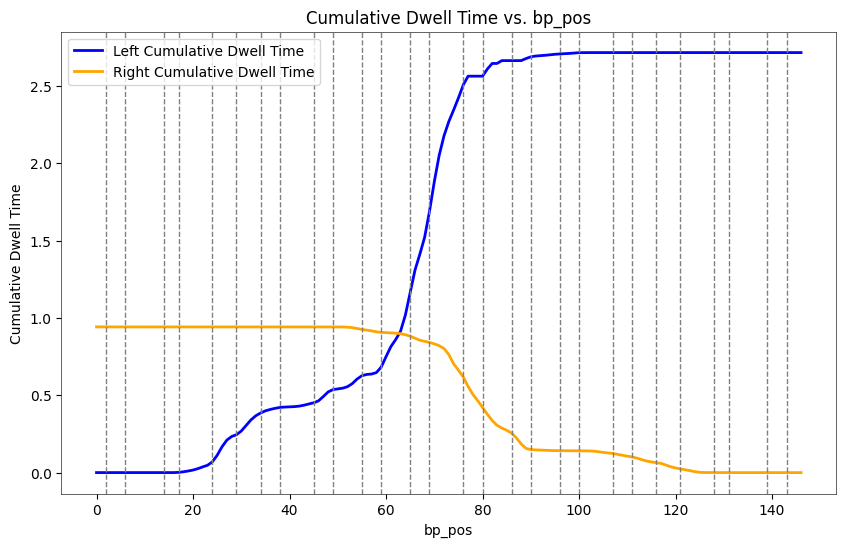

In [145]:
plt.figure(figsize=(10, 6))

plt.plot(left_zip_df['bp_pos'], left_zip_df['cumulative_dwell_time'], lw=2, color='blue', label='Left Cumulative Dwell Time')
plt.plot(right_zip_df['bp_pos'], right_zip_df['cumulative_dwell_time'], lw=2, color='orange', label='Right Cumulative Dwell Time')
for site in PHOSPHATE_SITES:
    plt.axvline(site, color='gray', linestyle='--', lw=1)
plt.xlabel('bp_pos')
plt.ylabel('Cumulative Dwell Time')
plt.title('Cumulative Dwell Time vs. bp_pos')
plt.legend()
plt.show()


In [146]:
left_zip_phsite_df =  left_zip_df[left_zip_df['bp_pos'].isin(PHOSPHATE_SITES)]

## Subtract 1 from the bp_pos because when zipping from right the bp will be of right to the bound phosphate. And since in the phosphate_sites 
## we are using the left base pair to represent the phosphate site, I need to make sure I select the dwell time for the base pair that is in the right 
## of the phosphate site, when I zip from the right.
right_zip_df["aligned_bp_position"] = right_zip_df["bp_pos"] - 1 ## This is to select the phosphate sites from the array. And also to match the left zip data. 

right_zip_phsite_df =  right_zip_df[right_zip_df['aligned_bp_position'].isin(PHOSPHATE_SITES)]

# right_ph_df =  right_zip_df[right_zip_df['bp_pos'].isin(phosphate_sites)]

dwell_LR_phsite_df = pd.merge(left_zip_phsite_df, right_zip_phsite_df, 
                           left_on='bp_pos', 
                           right_on="aligned_bp_position", 
                           suffixes=('_left', '_right'))



final_dwell_phsite_df = dwell_LR_phsite_df[["bp_pos_left", "cumulative_dwell_time_left", "cumulative_dwell_time_right"]]

final_dwell_phsite_df.rename(columns={"bp_pos_left":"phosphate_site", 
                                        "cumulative_dwell_time_left":"left_cumdwell_time", 
                                        "cumulative_dwell_time_right":"right_cumdwell_time"}, 
                                        inplace=True)

/tmp/ipykernel_93250/2989610663.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dwell_phsite_df.rename(columns={"bp_pos_left":"phosphate_site",


In [147]:
KRESCFACTOR = 1.0

if HARD_CONS:
    ############## HARD CONSTRAITNS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_hc.csv")
else:
    ############## SOFT CONSTRAINTS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_sc.csv")

#############################################
#####FLIPPED SEQUENCE #######################
#############################################
df_full_flip = pd.read_csv(RESULTS_DIR / f"nbfiles/dna_histone/breathstatefe_K{KRESCFACTOR}_sc_flip.csv")


### SELECT ONLY THE 601 SEQUENCE

df_full = df_full[df_full["id"]=="601"]
df_full_flip = df_full_flip[df_full_flip["id"]=="601"]


In [152]:
def get_LR_df_with_phsite(df):

    df_left = df[df['right_open']==0].reset_index(drop=True)
    df_right = df[df['left_open']==0].reset_index(drop=True)

    df_left['phosphate_site'] = np.where(
        df_left['leftbind_indx'] < len(PHOSPHATE_SITES),
        df_left['leftbind_indx'].astype(int).map(lambda i: PHOSPHATE_SITES[i]),
        np.nan
    )

    df_right['phosphate_site'] = np.where(
        df_right['rightbind_indx'] < len(PHOSPHATE_SITES),
        df_right['rightbind_indx'].astype(int).map(lambda i: PHOSPHATE_SITES[i]),
        np.nan
    )

    df_left = df_left[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]
    df_right = df_right[["phosphate_site", "id", "F", "F_entropy", "F_enthalpy", "F_freedna", "dF"]]

    return df_left, df_right

In [153]:
#############################################
#####ORIGINAL SEQUENCE ######################
#############################################

df_org_L, df_org_R = get_LR_df_with_phsite(df_full)

#############################################
#####FLIPPED SEQUENCE #######################
#############################################

df_flip_L, df_flip_R = get_LR_df_with_phsite(df_full_flip)

In [154]:
from enum import Enum, auto
from dataclasses import dataclass, field
from typing import List, Tuple


class Orientation(Enum):
    """Physical orientation of the DNA on the histone octamer."""

    ORIGINAL = auto()  # −73 → +73 (as in the crystal structure)
    FLIPPED = auto()   # same octamer rotated 180°, so +73 → −73

    @property
    def is_flipped(self) -> bool:
        return self is Orientation.FLIPPED


In [162]:
@dataclass(frozen=True)
class EadsResult:
    """Computed adsorption energies for *one* orientation."""

    orientation: Orientation

    Eads_Base_left: pd.Series
    Eads_Base_right: pd.Series

    Eads_dG_left: pd.Series
    Eads_dG_right: pd.Series

    Eads_dH_left: pd.Series
    Eads_dH_right: pd.Series

    # raw pieces (handy for debugging / further analysis)
    tau_left: pd.Series = field(repr=False)
    tau_right: pd.Series = field(repr=False)
    dG_left: pd.Series = field(repr=False)
    dG_right: pd.Series = field(repr=False)
    dH_left: pd.Series = field(repr=False)
    dH_right: pd.Series = field(repr=False)



In [156]:
def _prepare_orientation(tau_left:pd.Series, tau_right:pd.Series, 
                         left_dG_df:pd.DataFrame, right_dG_df:pd.DataFrame, 
                         orientation: Orientation) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series]:
    """Return tau and ΔG/ΔH arrays mapped into *physical* left → right order.
    tau_left: pd.Series  # from experimental unwrapping −73 → +73
    tau_right: pd.Series  # from experimental unwrapping +73 → −73 
    left_dG_df: pd.DataFrame  # Left is with respect to the histone octamer orientation example: 0 → 27 
    right_dG_df: pd.DataFrame  # Right is with respect to the histone octamer orientation example: 0 → 27
    orientation: Orientation  # physical orientation of the DNA on the histone octamer"""



      # ---------- LEFT SIDE ENERGY (RELATIVE TO DYAD)  ------------------
    dG_L  = left_dG_df['dF'].diff().shift(-1)         
    dH_L = left_dG_df['F_enthalpy'].diff().shift(-1)         

    dG_L.iloc[-1] = 0
    dH_L.iloc[-1] = 0  

    dG_L, dH_L  = dG_L.reset_index(drop=True), dH_L.reset_index(drop=True)                



    # ---------- RIGHT SIDE ENERGY (RELATIVE TO DYAD) ------------------
    tempF_R = right_dG_df['dF'][::-1].reset_index(drop=True)
    tempF_R_enthalpy = right_dG_df['F_enthalpy'][::-1].reset_index(drop=True)

    dG_R  = tempF_R.diff().shift(-1)                   
    dG_R.iloc[-1] = 0

    dH_R  = tempF_R_enthalpy.diff().shift(-1)                   
    dH_R.iloc[-1] = 0

    dG_R, dH_R  = dG_R[::-1].reset_index(drop=True), dH_R[::-1].reset_index(drop=True)

    if orientation.is_flipped:
          tau_L = tau_right[::-1].reset_index(drop=True)
          tau_R = tau_left[::-1].reset_index(drop=True)

    else:
          tau_L = tau_left.reset_index(drop=True)
          tau_R = tau_right.reset_index(drop=True)

    return tau_L, tau_R, dG_L, dG_R, dH_L, dH_R

In [343]:
def single_eads(tau:pd.Series, dG:pd.Series, dH:pd.Series, kBT:float, tau_0:float) -> Tuple[float, float]:
    Eads_base = kBT*np.log(tau / tau_0) 
    Eads_dG = Eads_base - dG 
    Eads_dH = Eads_base- dH 
    return Eads_base, Eads_dG, Eads_dH

In [317]:
def get_Eads_values(Tau_cum_df:pd.DataFrame, 
                    forward_dG_df:pd.DataFrame,
                      reverse_dG_df:pd.DataFrame,
                       orientation:Orientation, 
                         tau_0:float=1e-6, kBT:float=1.0)->tuple:



    # ---------- LEFT  (forward zipping) From Experiment on the original orientation of 601 ------------------
    tau_L = Tau_cum_df['left_cumdwell_time'].diff().fillna(Tau_cum_df['left_cumdwell_time'].iloc[0]) # first row has no upstream neighbour, so filled with its own value
    tau_L = tau_L.reset_index(drop=True)               
   


    # ---------- RIGHT  (reverse zipping) From Experiment on the original orientation of 601 ------------------
    cumT_R = Tau_cum_df['right_cumdwell_time'][::-1].reset_index(drop=True)
    tau_R = cumT_R.diff().fillna(cumT_R.iloc[0])      
    tau_R = tau_R[::-1].reset_index(drop=True)


    tau_L, tau_R, dG_L, dG_R, dH_L, dH_R = _prepare_orientation(tau_left=tau_L, tau_right=tau_R,
                                                                                     left_dG_df=forward_dG_df, right_dG_df=reverse_dG_df,
                                                                                     orientation=orientation)

    Eads_L, Eads_L_dG, Eads_L_dH = single_eads(tau=tau_L, dG=dG_L, dH=dH_L, kBT=kBT, tau_0=tau_0)
    Eads_R, Eads_R_dG, Eads_R_dH = single_eads(tau=tau_R, dG=dG_R, dH=dH_R, kBT=kBT, tau_0=tau_0)
    

    # sanitise infinities caused by zero dwell times
    for s in (Eads_L, Eads_R, Eads_L_dG, Eads_R_dG, Eads_L_dH, Eads_R_dH):
        s.replace([np.inf, -np.inf], 0, inplace=True)


    return EadsResult(
        orientation,
        Eads_Base_left=Eads_L,
        Eads_Base_right=Eads_R,
        Eads_dG_left=Eads_L_dG,
        Eads_dG_right=Eads_R_dG,
        Eads_dH_left=Eads_L_dH,
        Eads_dH_right=Eads_R_dH,
        tau_left=tau_L,
        tau_right=tau_R,
        dG_left=dG_L,
        dG_right=dG_R,
        dH_left=dH_L,
        dH_right=dH_R
    )

In [318]:
G_0 = -10
tau_0 = 1e-6*np.exp(G_0)
EadsResult_org = get_Eads_values(Tau_cum_df=final_dwell_phsite_df, 
                              forward_dG_df=df_org_L, 
                              reverse_dG_df=df_org_R, 
                              orientation=Orientation.ORIGINAL,
                              tau_0=tau_0)

EadsResult_flipped = get_Eads_values(Tau_cum_df=final_dwell_phsite_df,
                                    forward_dG_df=df_flip_L, 
                                    reverse_dG_df=df_flip_R, 
                                    orientation=Orientation.FLIPPED,
                                    tau_0=tau_0)

/home/pol_schiessel/maya620d/anaconda3/envs/nucleosome/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [319]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def plot_tau_dg(results:list[EadsResult], *, figsize=(12, 8)):
    """
    Plot dwell time (τ) and step ΔG for left/right unwrapping
    in **original** and **flipped** orientations.

    Parameters
    ----------
    results : list[EadsResult]
        Typically `[eads_original, eads_flipped]`.  Order decides
        which row is plotted first.
    figsize : tuple[int, int]
        Size passed to `plt.subplots()`.

    Notes
    -----
    • Solid line with circles  = τ  (left y-axis)  
    • Dashed line with crosses = ΔG (right y-axis)
    • Plots with same color are same sequences 
    """
    if len(results) != 2:
        raise ValueError("Provide exactly two EadsResult objects (orig & flip)")

    # ensure deterministic row order: ORIGINAL row 0, FLIPPED row 1
    res_sorted = sorted(results, key=lambda r: r.orientation.value)

    fig, axs = plt.subplots(2, 2, figsize=figsize, sharex=True)
    fig.tight_layout(pad=2.0)

    # colour matrix → diagonal match
    c_diag, c_off = "tab:blue", "tab:orange"
    colour = [[c_diag, c_off],          # row 0
              [c_off, c_diag]]      

    # --- helper for one axis --------------------------------------------------
    def _axis(ax, x, tau, dG, side_label, color):
        ax.plot(x, tau, marker="o", linestyle="-", color=color)
        ax.set_ylabel(f"τ {side_label}", color=color)
        ax.tick_params(axis="y", labelcolor=color)
        ax.grid(True, linestyle="--", alpha=0.6)
        sns.despine(ax=ax, left=True, bottom=True)

        ax2 = ax.twinx()
        ax2.plot(x, dG, marker="x", linestyle="--", color=color)
        ax2.set_ylabel(f"ΔG {side_label}", color=color)
        ax2.tick_params(axis="y", labelcolor=color)

    # --- iterate over orientations & sides -----------------------------------
    for row, res in enumerate(res_sorted):
        orient = "original" if not res.orientation.is_flipped else "flipped"
            
        _axis(
            axs[row, 0],
            x=PHOSPHATE_SITES,
            tau=res.tau_left,
            dG=res.dG_left,
            side_label=f"(L, {orient})",
            color=colour[row][0],
        )
        axs[row, 0].set_title(f"τ & ΔG – left unwrap ({orient})")

        _axis(
            axs[row, 1],
            x=PHOSPHATE_SITES,
            tau=res.tau_right,
            dG=res.dG_right,
            side_label=f"(R, {orient})",
            color=colour[row][1],
        )
        axs[row, 1].set_title(f"τ & ΔG – right unwrap ({orient})")
        axs[row, 1].set_xlabel("Phosphate site (bp)")

    fig.suptitle("Dwell‐time vs. step ΔG per orientation & side", y=1.03)
    plt.tight_layout()
    plt.show()


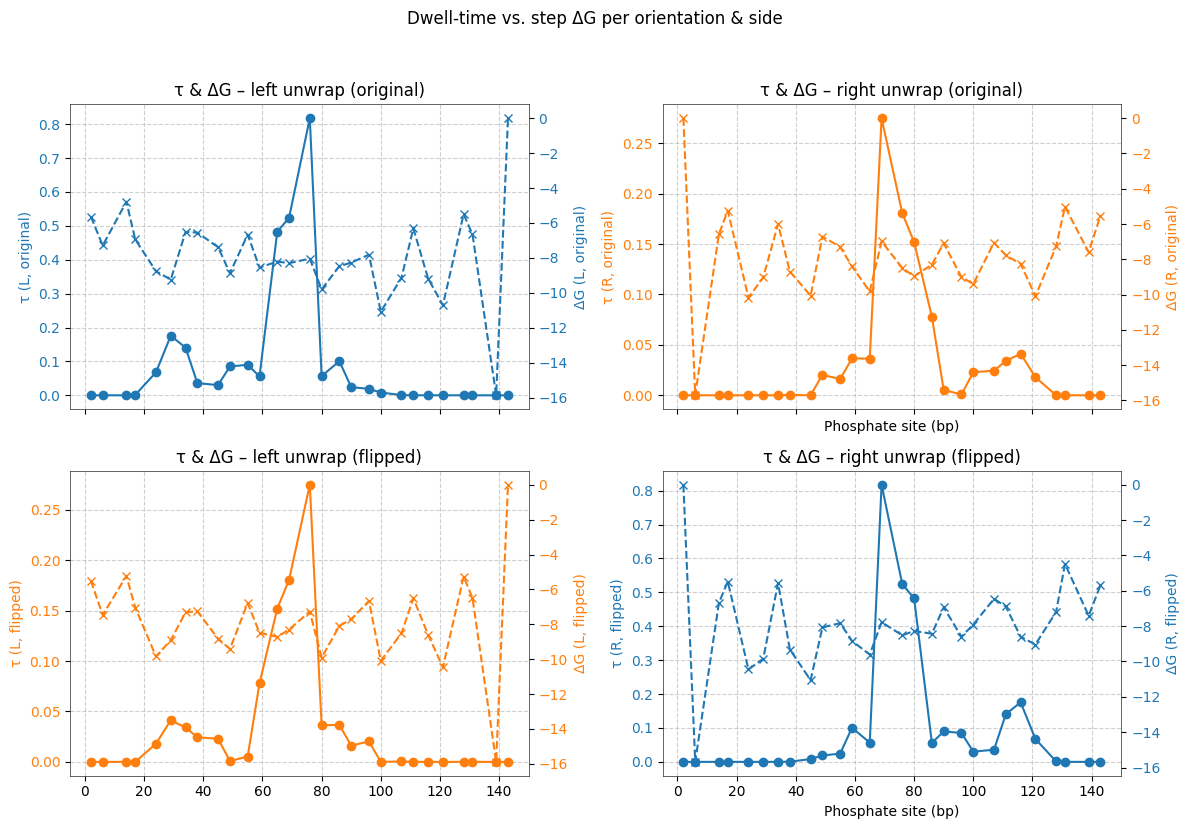

In [320]:
plot_tau_dg([EadsResult_org, EadsResult_flipped], figsize=(12, 8))

In [321]:
def _single_axis(ax: plt.Axes, x: List[int], y_left: pd.Series, y_right: pd.Series, *, title: str, ylabel: str, label_left: str, label_right: str, colour_left: str, colour_right: str) -> None:
    ax.plot(x, y_left, "-o", label=label_left, linewidth=2, alpha=0.85, color=colour_left)
    ax.plot(x, y_right, "--x", label=label_right, linewidth=2, alpha=0.85, color=colour_right)
    ax.set_title(title)
    ax.set_xlabel("Phosphate site (bp)")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    sns.despine(ax=ax)

In [322]:
def plot_eads_elegant(results: List[EadsResult], *, seq_id:str, figsize: Tuple[int, int] = (20, 10)) -> None:
    """Elegant 2x3 comparison of basic/full/enthalpy energies.

    • Row_0 = original orientation (blue left, red right)
    • Row_1 = flipped   orientation (red  left, blue right)
    """
    if len(results) != 2:
        raise ValueError("Provide exactly two EadsResult objects (original & flipped)")

    # deterministic order: ORIGINAL first row, FLIPPED second
    res_sorted = sorted(results, key=lambda r: r.orientation.value)

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharey=True)

    plot_map = [
        ("Eads_Base_left", "Eads_Base_right", r"$E_{ads}\,(k_B T)$", "Basic"),
        ("Eads_dG_left", "Eads_dG_right", r"$E_{ads}^{full}\,(k_B T)$", "Free‑energy"),
        ("Eads_dH_left", "Eads_dH_right", r"$E_{ads}^{enth}\,(k_B T)$", "Enthalpy"),
    ]

    colours = (
        ("tab:blue", "tab:red"),   # original row
        ("tab:red", "tab:blue"),   # flipped  row (swapped)
    )

    for row, res in enumerate(res_sorted):
        left_col, right_col = colours[row]
        orient_lbl = "Orig" if res.orientation is Orientation.ORIGINAL else "Flip"

        for col, (attr_L, attr_R, ylabel, ttl) in enumerate(plot_map):
            _single_axis(
                axes[row, col],
                PHOSPHATE_SITES,
                getattr(res, attr_L),
                getattr(res, attr_R),
                title=f"{ttl} ({orient_lbl})",
                ylabel=ylabel if col == 0 else "",
                label_left="left-unwrap",
                label_right="right-unwrap",
                colour_left=left_col,
                colour_right=right_col,
            )

    axes[0, 0].legend(frameon=True)
    fig.suptitle(f"Unzipping energy landscape for Sequence {seq_id}", y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()


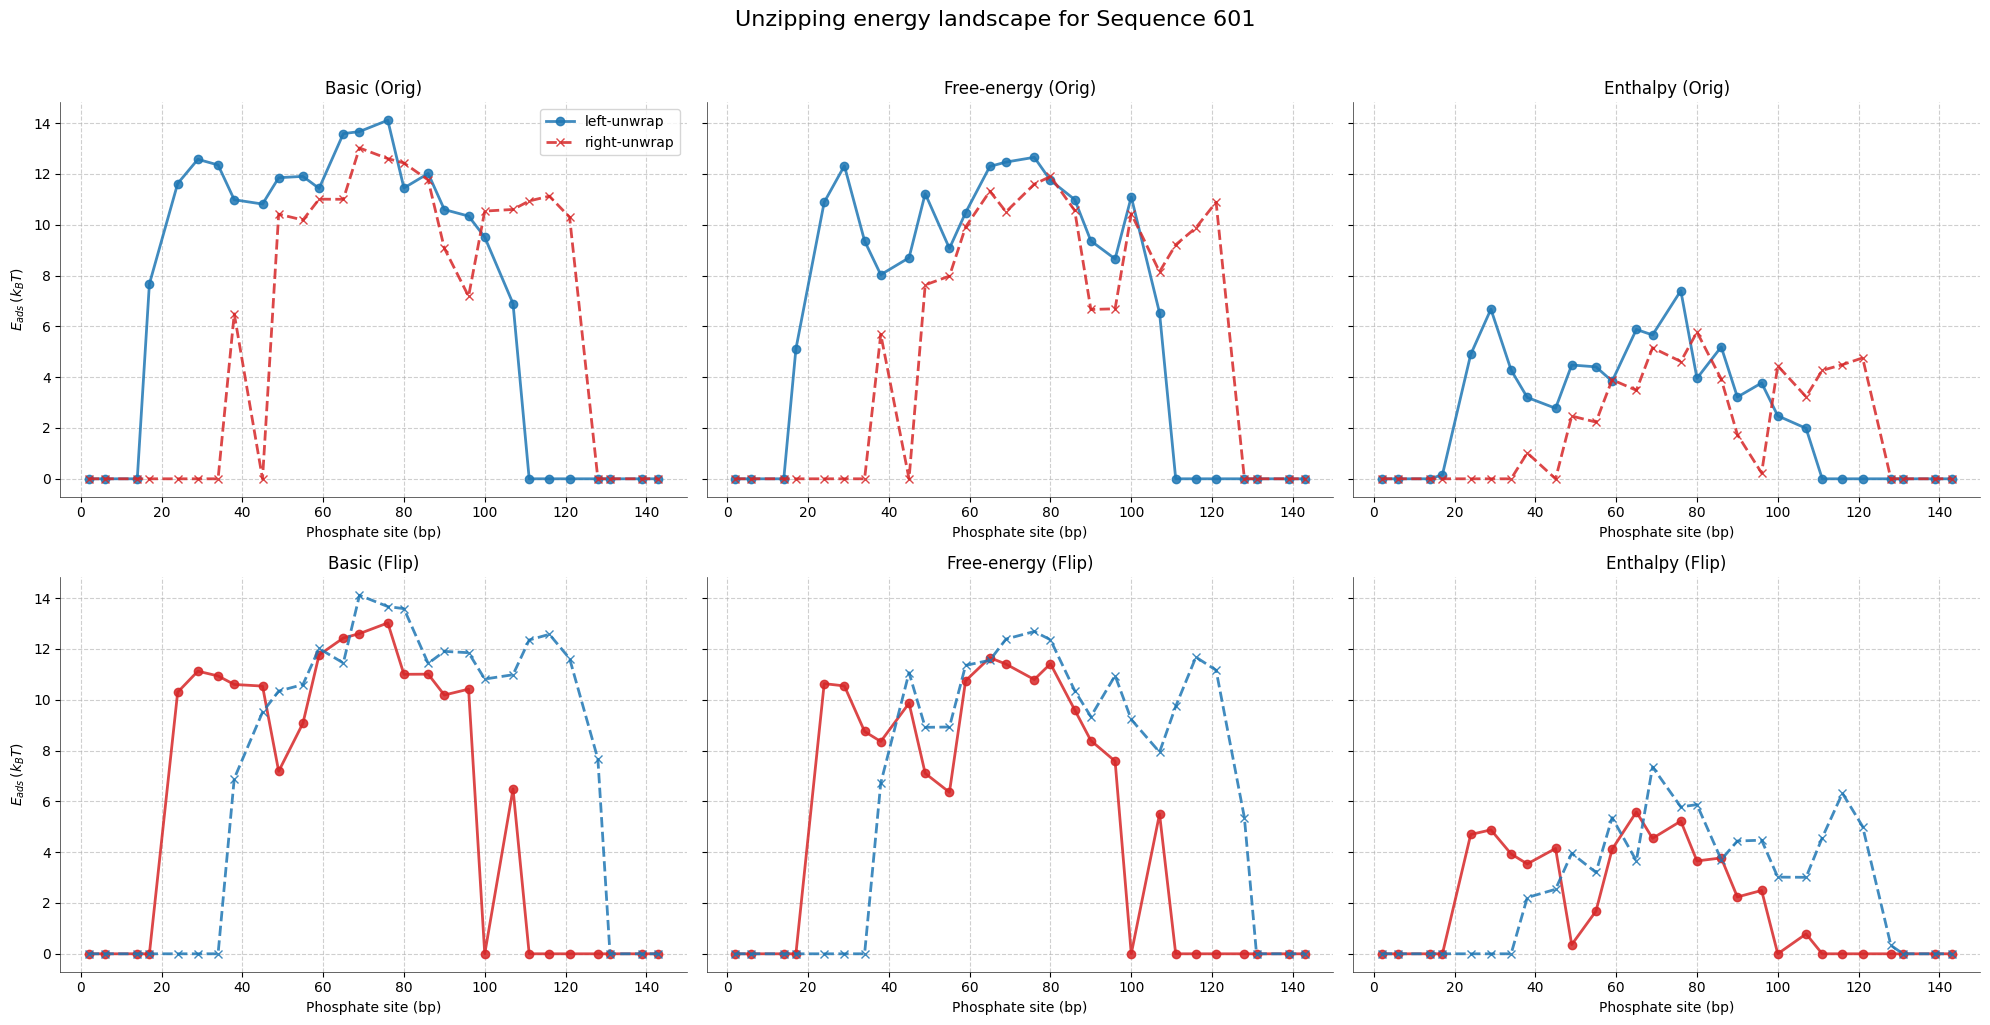

In [323]:
plot_eads_elegant([EadsResult_org, EadsResult_flipped], seq_id="601", figsize=(20, 10))

In [324]:



avgEads_df = pd.concat([
    EadsResult_org.Eads_dG_left,
    EadsResult_org.Eads_dG_right,
    EadsResult_flipped.Eads_dG_left,
    EadsResult_flipped.Eads_dG_right
], axis=1)

avgEads_phlevel = avgEads_df.mean(axis=1)
Eads_bndsite_level = pd.Series(
    avgEads_phlevel.values.reshape(-1, 2).sum(axis=1)
)

df_Eads_bndsite_level = Eads_bndsite_level.to_frame(name='Eads')
df_Eads_bndsite_level["index"] = df_Eads_bndsite_level.index

In [325]:
# df_Eads_bndsite_level.loc[df_Eads_bndsite_level["index"] == 13, "Eads"] = 3.589996	
# df_Eads_bndsite_level.loc[df_Eads_bndsite_level["index"] == 0, "Eads"] = 3.528168


# Nuc Breathing with Calculated Adsorption Energies (from Michelle D paper)
### doi:10.1038/nsmb.1526

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from py_analysis.utils.plot_2d_heatmaps import plot_probability_heatmaps
from py_analysis.utils.plot_3d import plot_3d_filled_volume

In [327]:
KRESCFACTOR = 1.0

if HARD_CONS:
    ############## HARD CONSTRAITNS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_hc.csv")
else:
    ############## SOFT CONSTRAINTS ######################
    df_full = pd.read_csv(RESULTS_DIR / f"nbfiles/nucbreathfe/breathstatefe_K{KRESCFACTOR}_sc.csv")

In [341]:
###Temporary
tau_0 = 5e-12
# G_0 = 3
# tau_0 = 1e-6*np.exp(G_0)

EadsResult_org = get_Eads_values(Tau_cum_df=final_dwell_phsite_df, 
                              forward_dG_df=df_org_L, 
                              reverse_dG_df=df_org_R, 
                              orientation=Orientation.ORIGINAL,
                              tau_0=tau_0)

EadsResult_flipped = get_Eads_values(Tau_cum_df=final_dwell_phsite_df,
                                    forward_dG_df=df_flip_L, 
                                    reverse_dG_df=df_flip_R, 
                                    orientation=Orientation.FLIPPED,
                                    tau_0=tau_0)



avgEads_df = pd.concat([
    EadsResult_org.Eads_dG_left,
    EadsResult_org.Eads_dG_right,
    EadsResult_flipped.Eads_dG_left,
    EadsResult_flipped.Eads_dG_right
], axis=1)

avgEads_phlevel = avgEads_df.mean(axis=1)
Eads_bndsite_level = pd.Series(
    avgEads_phlevel.values.reshape(-1, 2).sum(axis=1)
)



/home/pol_schiessel/maya620d/anaconda3/envs/nucleosome/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_93250/586540343.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


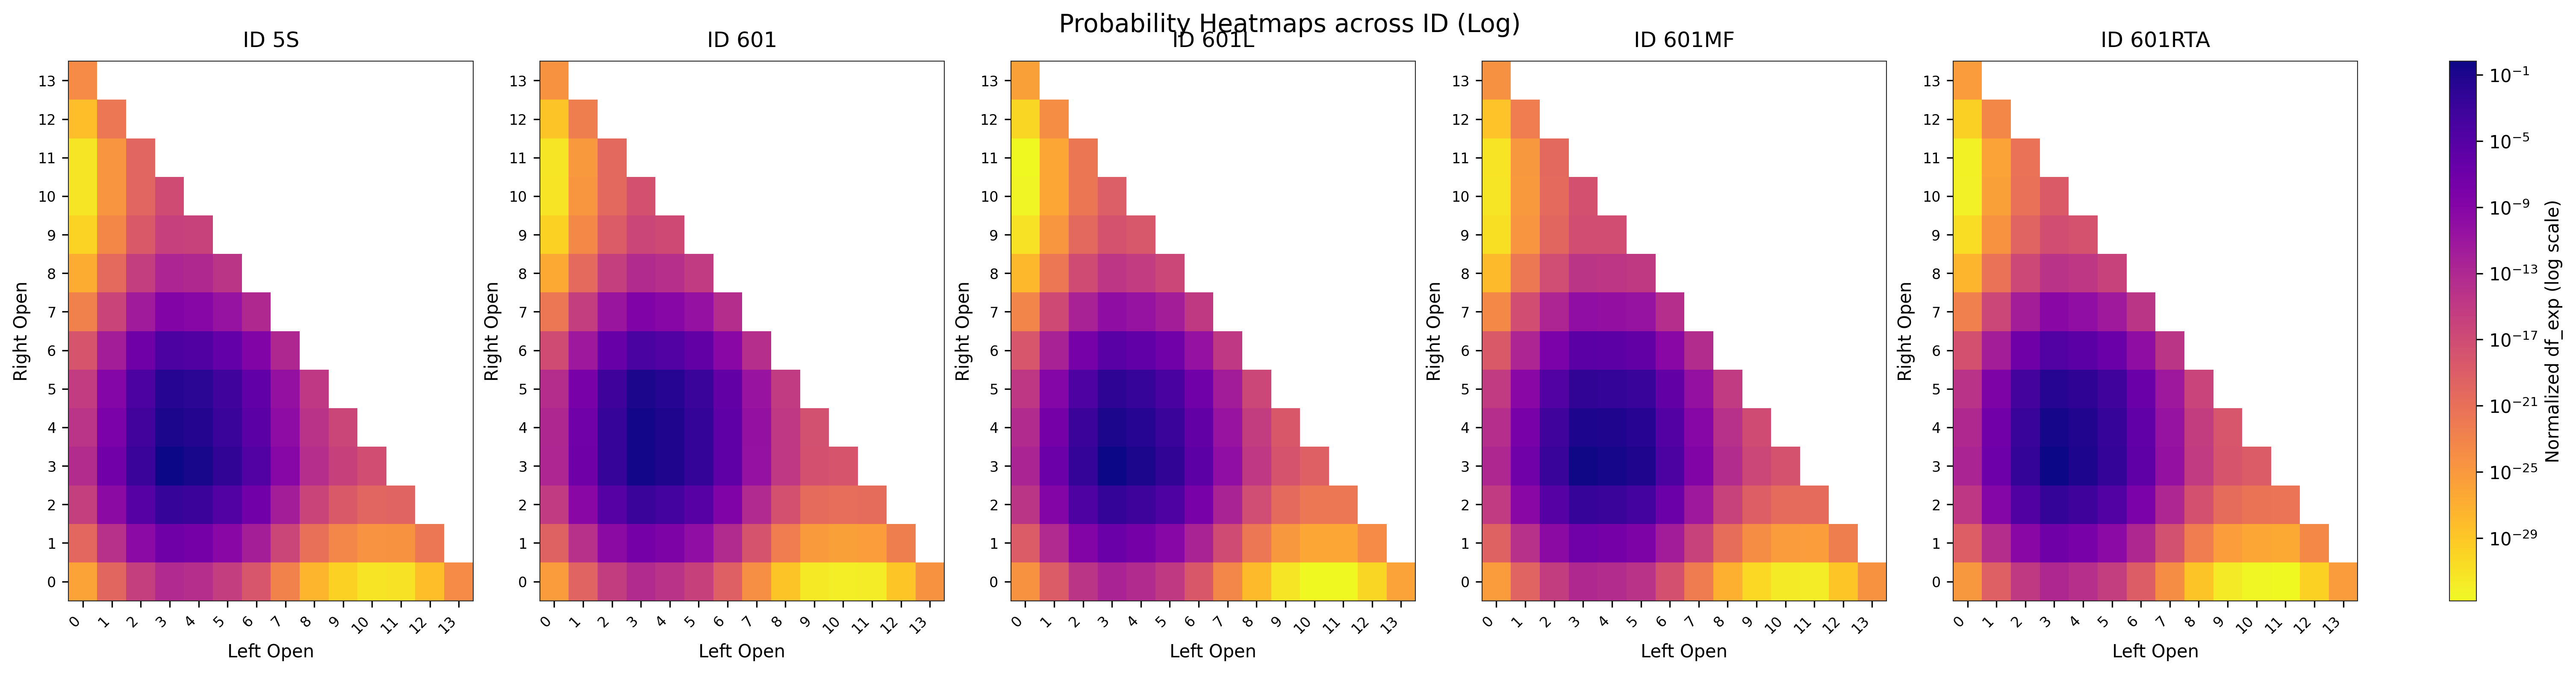

In [342]:
df_full["Adsorp_F"] = df_full.apply(
    lambda row: -Eads_bndsite_level[int(row["left_open"]) : (14 - int(row["right_open"]))].sum(),
    axis=1
)

df_full["dF_total"] = df_full["dF"] + df_full["Adsorp_F"]

df_full["df_exp"]= df_full["dF_total"].apply(lambda x: np.exp(-x))
df_full["df_exp_norm"] = df_full.groupby("id")["df_exp"].transform(lambda x: x / x.sum())


fig, axs = plot_probability_heatmaps(
    df_full,
    value_col='df_exp_norm',
    id_col='id',
    x_col='left_open',
    y_col='right_open',
    xlabel='Left Open',
    ylabel='Right Open',
    log_scale=True,
    colormap='plasma_r',
    figsize=(20, 5),
    suptitle="Probability Heatmaps across ID (Log)", dpi=300, colorbar_label = 'Normalized df_exp (log scale)'
)
fig.show()

In [271]:
Eads_bndsite_level

0      0.000000
1      1.225583
2     10.886590
3     11.412960
4     15.758989
5     18.286440
6     22.979972
7     23.370942
8     18.399666
9     15.790598
10    11.453948
11    10.692728
12     1.287411
13     0.000000
dtype: float64